In [65]:
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt


In [66]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [67]:
# create itos and stoi
chars = sorted(set(''.join(words)))
itos = {i+1: ch for i, ch in enumerate(chars)}
itos[0] = '.'
stoi = {ch: i for i, ch in itos.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [68]:
import numpy as np
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)

    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [69]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [70]:
from typing import Any


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ (fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        p = [self.weight] + ([] if self.bias is None else [self.bias])
        return p
    

class BatchNorm1d:
    def __init__(self, dim, esp=1e-5, momentum=0.1):
        self.esp = esp
        self.momentum = momentum
        self.training = True
        # running mean to keep track of things
        self.mean_running = torch.zeros(1,dim)
        self.std_running = torch.ones(1, dim)
        # paramaters for normalization
        self.gamma = torch.ones(1, dim)
        self.beta = torch.zeros(1, dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.mean_running
            xvar = self.std_running
            
        xhat = (x - xmean) / (xvar + self.esp)
        if self.training:
            with torch.no_grad():
                self.mean_running = self.mean_running * (1-self.momentum) + xmean * self.momentum
                self.std_running = self.std_running * (1-self.momentum) + xvar * self.momentum

        self.out = self.gamma * xhat + self.beta
        return self.out
        
    def parameters(self):
        return [self.gamma, self.beta]
        
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]
    

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    
class Sequetial:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [71]:
torch.manual_seed(42); # seed rng for reproducibility


In [82]:
n_embd = 10
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)

model = Sequetial([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22097


In [73]:
# run optimisationz

max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 1000 == 0:
        print(f"{i}: {loss.item()}")
    
    
    lossi.append(loss.log10().item())


0: 3.2790465354919434
1000: 2.4495599269866943
2000: 2.366957902908325
3000: 2.8445093631744385
4000: 2.5566484928131104
5000: 2.1794235706329346
6000: 2.3896682262420654
7000: 2.06724214553833
8000: 2.04648756980896
9000: 2.519988536834717
10000: 2.4507968425750732
11000: 2.0305581092834473
12000: 2.455108165740967
13000: 2.3339037895202637
14000: 2.7375271320343018
15000: 2.6606531143188477
16000: 2.2050106525421143
17000: 2.651179075241089
18000: 2.5478694438934326
19000: 2.4080147743225098
20000: 2.2041187286376953
21000: 2.6309406757354736
22000: 2.085845947265625
23000: 2.2536203861236572
24000: 2.455277681350708
25000: 2.207866907119751
26000: 2.153071403503418
27000: 2.481184482574463
28000: 2.2301688194274902
29000: 2.1282737255096436
30000: 2.327691078186035
31000: 2.3706908226013184
32000: 2.4204154014587402
33000: 2.428619861602783
34000: 2.370342254638672
35000: 1.87179696559906
36000: 2.174492835998535
37000: 2.159252882003784
38000: 1.9270364046096802
39000: 2.2004959583

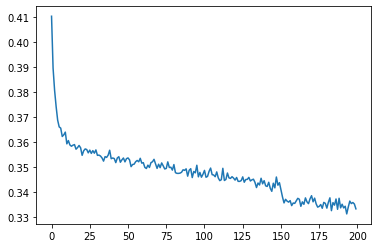

In [78]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [79]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [80]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.141568899154663
val 2.159745216369629


In [81]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

svryona.
vabele.
sradsy.
tyriel.
trip.
chysten.
brostson.
kayro.
bavary.
kaven.
yvee.
keilean.
ariahna.
ellais.
kadee.
bisthrekol.
quesfeh.
mailin.
lurnoen.
naellionn.
